### load all the libraries ###

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
# Variables to set the number of epochs and samples
num_epochs = 10
num_samples = 100  # set this to -1 to use all data

In [12]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.version.cuda)
print(device)

None
cpu


### load the dataset and the model tokenizer ###

In [2]:
# Step 1: Load dataset and model tokenizer
dataset = load_dataset('imdb')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Found cached dataset imdb (C:/Users/matth/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 136.35it/s]
d:\Users\matth\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\matth\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us

### create a plot to see the distribution of the positive and negative classes ###

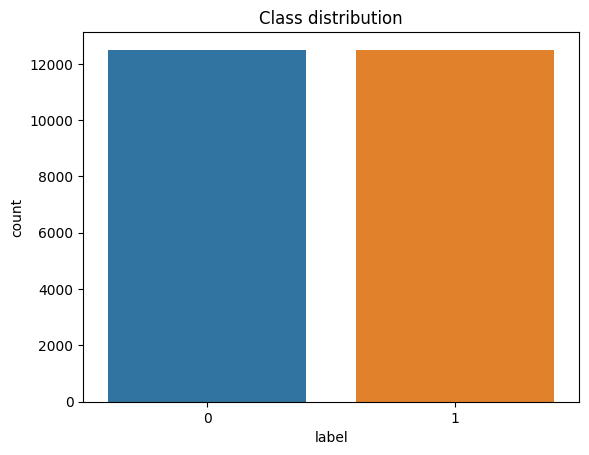

In [3]:
# Data Exploration
train_df = pd.DataFrame(dataset["train"])
sns.countplot(x='label', data=train_df)
plt.title('Class distribution')
plt.show()

### preprocess our dataset by tokenizing the texts. We use BERT’s tokenizer, which will convert the text into tokens that correspond to BERT’s vocabulary ###

In [4]:
# Step 2: Preprocess the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# prepare our training and evaluation datasets. Remember, if you want to use all the data, you can set the num_samples variable to -1 ###

In [5]:
if num_samples == -1:
    small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
    small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)
else:
    small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(num_samples)) 
    small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(num_samples)) 


### load the pre-trained BERT model. We’ll use the AutoModelForSequenceClassification class, a BERT model designed for classification tasks ###

### *use the ‘bert-base-uncased’ version of BERT, which is trained on lower-case English text* ###

In [6]:
# Step 3: Load pre-trained model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### define our training arguments and create a Trainer instance to train our model. ###

In [7]:
# Step 4: Define training arguments
training_args = TrainingArguments("test_trainer", evaluation_strategy="epoch", no_cuda=True, num_train_epochs=num_epochs)

# Step 5: Create Trainer instance and train
trainer = Trainer(
    model=model, args=training_args, train_dataset=small_train_dataset, eval_dataset=small_eval_dataset
)

trainer.train()

d:\Users\matth\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  1%|          | 1/130 [00:16<36:11, 16.83s/it]

KeyboardInterrupt: 

### Interpreting Results ###
Having trained our model, let’s evaluate it. We’ll calculate the confusion matrix and the ROC curve to understand how well our model performs.



In [ ]:
# Step 6: Evaluation
predictions = trainer.predict(small_eval_dataset)

# Confusion matrix
cm = confusion_matrix(small_eval_dataset['label'], predictions.predictions.argmax(-1))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(small_eval_dataset['label'], predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(1.618 * 5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### The confusion matrix gives a detailed breakdown of how our predictions measure up to the actual labels, while the ROC curve shows us the trade-off between the true positive rate (sensitivity) and the false positive rate (1 — specificity) at various threshold settings ###

### see our model in action, use it to infer the sentiment of a sample text ###

In [ ]:
# Step 7: Inference on a new sample
sample_text = "This is a fantastic movie. I really enjoyed it."
sample_inputs = tokenizer(sample_text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

# Move inputs to device (if GPU available)
sample_inputs.to(training_args.device)

# Make prediction
predictions = model(**sample_inputs)
predicted_class = predictions.logits.argmax(-1).item()

if predicted_class == 1:
    print("Positive sentiment")
else:
    print("Negative sentiment")